In [2]:
from __future__ import division
from math import *
import random, os, sys
from dataRead import readMat, normalize
from config import data_config
from roboticsAI.utils import motionFCN, gradient_1, gradient_2, resample2, resample1
from roboticsAI.customPF import particles
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# prepare data & choose arbitary dimension
data_path = os.path.join(data_config['root_dir'], data_config['data_name'])
measurements = normalize(readMat(data_path))
print(measurements.shape)
Dims, Length = measurements.shape

# dim = 7
dim = int(random.random() * Dims)
data_mean = np.mean(measurements[dim, :])

(12, 138)


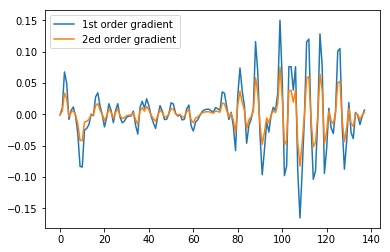

In [4]:
# gradient
g_1 = gradient_1(measurements[dim, :])
g_2 = gradient_2(measurements[dim, :])

plt.plot(g_1)
plt.plot(g_2)
plt.legend(['1st order gradient', '2ed order gradient'], loc='upper left')
plt.show()

In [5]:
''' 
    pred_range defines certain value range that only prediction without updating and resampling
    i.e. [64, 74] among total 138 data points would be prediction only 
'''

pred_range = [64, 110]

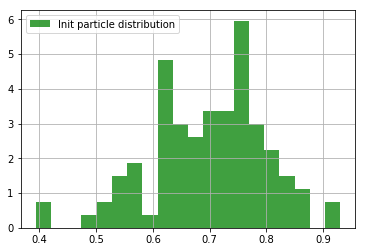

In [8]:
# init 100 particles 
N = 100
P = []
Estimation = []
Prediction = []

for i in range(N):
    x = particles()
    # x.set(random.uniform(0.5, 1), 0.005, 100.0, 1)
    x.set(random.gauss(data_mean, 0.1), 0.005, 5.0, 1)
    P.append(x)
    
plt.hist([y.x for y in P], 20, normed=1, facecolor='green', alpha=0.75)
plt.legend(['Init particle distribution'], loc='upper left')
plt.grid(True)
plt.show()

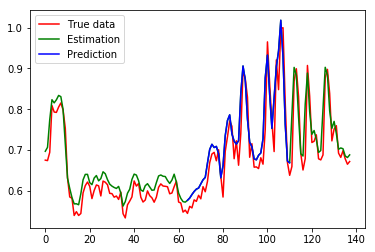

In [9]:
# run motion model
for t in range(Length):
    measurement = measurements[dim, t]

    if pred_range[0] <= t <= pred_range[1]:

        for n in range(N):
#             P[n].motion(motionFCN, v=g_1[t], a=g_2[t], t=1)
            P[n].motion(motionFCN, v=g_1[t], a=0, t=1)

        Prediction.append(np.mean([y.x for y in P]))
    
    else:

        # assign new Particle and Weight matrix
        W = []

        # motion
        for n in range(N): 

#             P[n].motion(motionFCN, v=g_1[t], a=g_2[t], t=1)
            P[n].motion(motionFCN, v=g_1[t], a=0, t=1)

            W.append(P[n].measurement_prob(measurement)) 

        ''' normal weights turns tobe important '''
        W1 = [i / (sum(W) + 1e-10) for i in W]
        W = W1

        '''plot weight changing'''
        # print(sum(W))
        # plt.plot(W)
        # plt.show()

        ''' resample1 from robotAI course '''
        # P = resample1(W, P)

        ''' resample2 '''
        P = resample2(W, P)

    # plot Particles after either pred or pred+update
    # plt.plot([y.x for y in P])
    # plt.show()

    # evaluation and store
    score = np.mean([y.x for y in P])
    Estimation.append(score)

''' print out prediction results'''
# print(Prediction)
# print(range(pred_range[0], pred_range[1] + 1))

# plot result
plt.figure(1)
plt.gca().set_color_cycle(['red', 'green', 'blue'])
plt.plot(measurements[dim, :])
plt.plot(Estimation)
plt.plot(range(pred_range[0], pred_range[1] + 1), Prediction)
plt.legend(['True data', 'Estimation', 'Prediction'], loc='upper left')
plt.show()